In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import decode_predictions
from keras.models import Model, load_model
import keras.backend as K

import model as tcav_model
import tcav as tcav
import utils as utils
import activation_generator as act_gen
import tensorflow as tf
import utils_plot as utils_plot


from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from numpy.linalg import norm

import pickle
#from bunch import bunchify

import cav as cav

from os import listdir
from os.path import isfile, join
import operator
from PIL import Image
from keras.preprocessing import image

import os
import math

import PIL.Image
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import preprocess_input



/data/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model = load_model('v3_model.h5')

Instructions for updating:
Colocations handled automatically by placer.


/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
sess = K.get_session()

endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],
)

tf.logging.set_verbosity(0)

working_dir = '/home/tyler/Desktop/tcav_on_azure'

label_path = os.path.join(working_dir,'labels.txt')

mymodel = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], endpoints_v3, 
        'InceptionV3_public', (-1, 1))

Instructions for updating:
Use tf.cast instead.


In [19]:
activation_dir

'/home/tyler/Desktop/tcav_on_azure/activations/'

In [31]:
## Run specific CAV
source_dir = working_dir + '/concepts/'
activation_dir =  working_dir + '/activations/'

hparams = tf.contrib.training.HParams(model_type='linear', alpha=.1)

#bottleneck = bottlenecks[0]
bottleneck = 'mixed9'
target_class = 'zebra'
concepts = ['banded_sub_1', 'random500_0']

act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=50)
acts = act_generator.process_and_load_activations([bottleneck], concepts + [target_class])
cav.get_or_train_cav(concepts,bottleneck,acts,cav_hparams=hparams,cav_dir='cavs')

['striped_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_striped_sub_1_mixed9 shape (50, 8, 8, 2048)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed9 shape (50, 8, 8, 2048)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed9 shape (50, 8, 8, 2048)
INFO:tensorflow:CAV already exists: cavs/striped_sub_1-random500_0-mixed9-linear-0.1.pkl


In [37]:
## CAV loop
target_class = 'zebra'
concepts = ['knitted_sub_1', 'random500_0']

bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9']
for bottleneck in  bn_names:
    acts = act_generator.process_and_load_activations([bottleneck], concepts + [target_class])
    cav.get_or_train_cav(concepts,bottleneck,acts,cav_hparams=hparams,cav_dir='cavs')


['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed0 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed0 shape (50, 35, 35, 256)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed0 shape (50, 35, 35, 256)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed0 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'knitted_sub_1': 0.7058823529411765, 'random500_0': 1.0, 'overall': 0.8484848484848485}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed0-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed1 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed1 shape (50, 35, 35, 288)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed1 shape (50, 35, 35, 288)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'knitted_sub_1': 1.0, 'random500_0': 0.7647058823529411, 'overall': 0.8787878787878788}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed1-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed2 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed2 shape (50, 35, 35, 288)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed2 shape (50, 35, 35, 288)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed2 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'knitted_sub_1': 0.9375, 'random500_0': 1.0, 'overall': 0.9696969696969697}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed2-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed3 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed3 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed3 shape (50, 17, 17, 768)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed3 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'knitted_sub_1': 1.0, 'random500_0': 0.6470588235294118, 'overall': 0.8181818181818182}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed3-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed4 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed4 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed4 shape (50, 17, 17, 768)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed4 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'knitted_sub_1': 0.9411764705882353, 'random500_0': 1.0, 'overall': 0.9696969696969697}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed4-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed5 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed5 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed5 shape (50, 17, 17, 768)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed5 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'knitted_sub_1': 0.9375, 'random500_0': 1.0, 'overall': 0.9696969696969697}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed5-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed6 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed6 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed6 shape (50, 17, 17, 768)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed6 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'knitted_sub_1': 1.0, 'random500_0': 1.0, 'overall': 1.0}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed6-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed7 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed7 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed7 shape (50, 17, 17, 768)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed7 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'knitted_sub_1': 1.0, 'random500_0': 0.8235294117647058, 'overall': 0.9090909090909091}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed7-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed8 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed8 shape (50, 8, 8, 1280)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed8 shape (50, 8, 8, 1280)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed8 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version
INFO:tensorflow:acc per class {'knitted_sub_1': 0.9411764705882353, 'random500_0': 1.0, 'overall': 0.9696969696969697}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed8-linear-0.1_test.pkl


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:did save save_path_lin_sep
['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed9 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed9 shape (50, 8, 8, 2048)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed9 shape (50, 8, 8, 2048)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed9 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version
INFO:tensorflow:acc per class {'knitted_sub_1': 1.0, 'random500_0': 1.0, 'overall': 1.0}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed9-linear-0.1_test.pkl


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:did save save_path_lin_sep


In [14]:
#working_dir = '/Users/tyler/Desktop/dissertation/programming/tcav'
working_dir = '/home/tyler/Desktop/tcav_on_azure'

activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
source_dir = working_dir + '/concepts/'

target = 'zebra'

concepts = ['banded_sub_1']   

#'mixed0','mixed1', 'mixed2', 'mixed3', 'mixed4', 'mixed5', 'mixed6', 'mixed7', 'mixed8', 'mixed9_0', 'mixed9', 'mixed9_1', 'mixed10'

bottlenecks = ['mixed4']

alphas = [0.1]

In [15]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=50)

tf.logging.set_verbosity(1)

num_random = 2

mytcav = tcav.TCAV(sess,
        target, concepts, bottlenecks,
        act_generator, alphas,
        cav_dir = cav_dir,
        num_random_exp=num_random)


INFO:tensorflow:mixed4 ['banded_sub_1', 'random500_0'] zebra 0.1
INFO:tensorflow:mixed4 ['banded_sub_1', 'random500_1'] zebra 0.1
INFO:tensorflow:mixed4 ['random500_0', 'random500_1'] zebra 0.1
INFO:tensorflow:mixed4 ['random500_1', 'random500_0'] zebra 0.1
INFO:tensorflow:TCAV will 4 params


In [16]:
results = mytcav.run(run_parallel=True)

INFO:tensorflow:running 4 params
INFO:tensorflow:running zebra ['banded_sub_1', 'random500_0']
INFO:tensorflow:running zebra ['banded_sub_1', 'random500_1']
['banded_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:running zebra ['random500_0', 'random500_1']
['banded_sub_1', 'random500_1', 'zebra']
INFO:tensorflow:running zebra ['random500_1', 'random500_0']
['random500_0', 'random500_1', 'zebra']['random500_1', 'random500_0', 'zebra']

INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed4 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_1_mixed4 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_1_mixed4 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed4 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed4 shap

/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'random500_0': 1.0, 'banded_sub_1': 1.0, 'overall': 1.0}
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/cavs/banded_sub_1-random500_0-mixed4-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_banded_sub_1_mixed4 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_1_mixed4 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed4 shape (50, 17, 17, 768)
INFO:tensorflow:Training CAV ['banded_sub_1', 'random500_1'] - mixed4 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'random500_1': 1.0, 'banded_sub_1': 1.0, 'overall': 1.0}
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/cavs/banded_sub_1-random500_1-mixed4-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
INFO:tensorflow:Done running 4 params. Took 88.13225317001343 seconds...


## Load CAV

In [61]:
working_dir = '/home/tyler/Desktop/tcav_on_azure'

class_1 = 'striped_sub_1'
class_2 = 'random500_0'
layer = 'mixed9'
lm_type = 'linear'

cav_name = class_1 + '-' + class_2 + '-' + layer + '-' + lm_type + '-0.1'
sub_path = 'cavs/' + cav_name + '.pkl'

path = os.path.join(working_dir, sub_path)
this_cav = cav.CAV.load_cav(path)

In [62]:
this_cav.concepts

['striped_sub_1', 'random500_0']

## Generate Activations

In [38]:
bottleneck = bottlenecks[0]
target_class = target

target_class,concepts = 'suit', ['banded_sub_1']
#my_class,concept = 'zebra','striped_sub_1'

acts = act_generator.process_and_load_activations([bottleneck], concepts + [target_class])


act_class = acts[target_class][bottleneck]
act_concept = acts[concepts[0]][bottleneck]


['banded_sub_1', 'suit']
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_banded_sub_1_mixed4 shape (50, 17, 17, 768)
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_suit_mixed4 does not exist, Making one...


In [39]:
## Activatons for images of different sizes

In [13]:
acts.keys()

dict_keys(['suit', 'banded_sub_1'])

In [185]:
# cosine similarity
def cosine_similarity(v1,v2):
    # compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy / math.sqrt(sumxx*sumyy)

## Sort Images by CAV

In [31]:
# image list
my_class = 'zebra'
path = 'activations/images_used_' + my_class + '.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)
    
image_list = data

In [33]:
# loop through files

cav_1 = this_cav.cavs[0]
cav_1 = cav_1.reshape(-1,1)

new_rank = {}

#for img_path, cos_sim in sorted_rank:
for img_path in image_list:
    filename = img_path

    img = np.array(PIL.Image.open(tf.gfile.Open(filename, 'rb')).convert('RGB').resize((299,299), PIL.Image.BILINEAR))
    img = np.float32(img) / 255.0
    
    acts_1 = mymodel.run_examples([img], 'mixed9')
    acts_shaped =  mymodel.reshape_activations(acts_1).squeeze()
    acts_shaped = acts_shaped.reshape(-1,1)
    cos = cosine_similarity(cav_1,acts_shaped)
    new_rank[img_path] = cos

new_sorted_rank = sorted(new_rank.items(), key=operator.itemgetter(1),reverse=True)

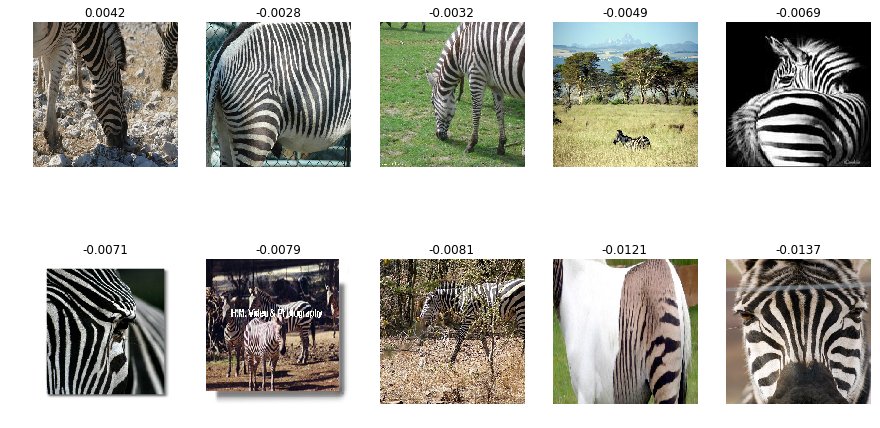

In [37]:
# plot by rank
w, h = 120, 120
fig = plt.figure(figsize=(15, 8))
columns, rows = 5, 2

start = 1

for i in range(1, columns*rows +1):
    img_path, cos = new_sorted_rank[start + i - 2]
    img = image.load_img(img_path, target_size=(299, 299))
    fig.add_subplot(rows, columns, i)
    plt.title(round(cos[0],4))
    plt.imshow(img)
    plt.axis('off')
plt.show()

## Perturb Activations

In [63]:
## first_part
tf.logging.set_verbosity(0)

to_mixed_9 = model.layers[279]
to_mixed_9.get_input_at(0)

mixed_9 = model.layers[280]
mixed_9.get_input_at(0)

first_part_endpoints = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=to_mixed_9.output[0].name,
    prediction=to_mixed_9.output[0].name,
    prediction_tensor=to_mixed_9.output[0],
)

first_part_model = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], first_part_endpoints, 
        'InceptionV3_public', (-1, 1))

In [64]:
## second_part
tf.logging.set_verbosity(0)
mixed_9 = model.layers[280]
mixed_9.get_input_at(0)

second_part_endpoints = dict(
    input=mixed_9.name,
    input_tensor=mixed_9.input,
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],
)


second_part_model = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], second_part_endpoints, 
        'InceptionV3_public', (-1, 1))

In [136]:
## load CAV
class_1 = 'striped_sub_1'
class_2 = 'random500_0'
layer = 'mixed9'
lm_type = 'linear'

cav_name = class_1 + '-' + class_2 + '-' + layer + '-' + lm_type + '-0.1'
sub_path = 'cavs/' + cav_name + '.pkl'

path = os.path.join(working_dir, sub_path)
this_cav = cav.CAV.load_cav(path)

In [177]:
# perturb
img_path = os.path.join(this_dir,imgs[7])
img = image.load_img(img_path, target_size=(299, 299))
img_array = np.array(img)
img_new_dims = np.expand_dims(img_array, axis=0)
img_input = preprocess_input(img_new_dims)

pred_1 = first_part_model.get_predictions(img_input)
pred_1 = np.expand_dims(pred_1, axis=0)

to_concept = class_1
this_alpha = 6
pred_1_pert = this_cav.perturb_act(pred_1,to_concept,alpha = this_alpha)

pred_2 = second_part_model.get_predictions(pred_1_pert)
decode_predictions(pred_2, top=5)

[[('n02389026', 'sorrel', 0.20539431),
  ('n02423022', 'gazelle', 0.071968764),
  ('n02412080', 'ram', 0.062063653),
  ('n02437616', 'llama', 0.049565714),
  ('n02391049', 'zebra', 0.04073301)]]

In [188]:
cav_1 = this_cav.cavs[0]
cav_1 = cav_1.reshape(-1,1)

pred_1_shaped = pred_1.squeeze().reshape(-1,1)
cos = cosine_similarity(cav_1,pred_1_shaped)

pred_1_pert_shaped = pred_1_pert.squeeze().reshape(-1,1)
cos_pert = cosine_similarity(cav_1,pred_1_pert_shaped)

print(cos,cos_pert)

[-0.05537518] [0.24518335]


In [211]:
act = pred_1
flat_act = np.reshape(act, -1)
alpha = 2
cav_from_class = this_cav.cavs[this_cav.concepts.index(class_1)]
pert = flat_act + alpha * cav_from_class

In [212]:
flat_act

array([0.        , 0.        , 0.59223706, ..., 0.3032995 , 0.719164  ,
       0.        ], dtype=float32)

In [213]:
pert

array([-0.04716826,  0.        ,  0.54760188, ...,  0.23324165,
        0.65593813, -0.01768581])

In [214]:
cav_from_class

array([-0.02358413,  0.        , -0.02231759, ..., -0.03502892,
       -0.03161294, -0.0088429 ])

In [187]:
cos

array([0.24518335])

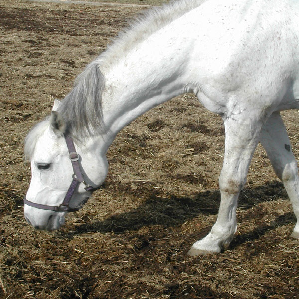

In [175]:
img

In [46]:
def files_from_dir(a_dir):
    onlyfiles = [f for f in os.listdir(a_dir) if os.path.isfile(os.path.join(a_dir, f))]
    return onlyfiles

In [167]:
this_dir = '/home/tyler/Desktop/tcav_on_azure/concepts/horse_sub_1/'
imgs = files_from_dir(this_dir)

In [168]:
img_path = os.path.join(this_dir,imgs[4])

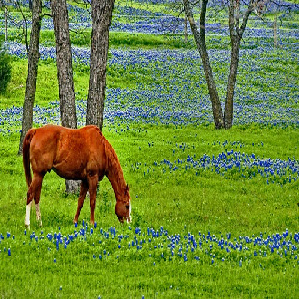

In [169]:
# Horse prediction
img = image.load_img(img_path, target_size=(299, 299))
img

In [55]:
img_array = np.array(img)
x = np.expand_dims(img_array, axis=0)
x = preprocess_input(x)

pred = mymodel.get_predictions(x)
decode_predictions(pred, top=5)

[[('n02389026', 'sorrel', 0.9454244),
  ('n04604644', 'worm_fence', 0.0039272704),
  ('n02403003', 'ox', 0.0012116004),
  ('n02437616', 'llama', 0.0010006261),
  ('n02793495', 'barn', 0.00072943774)]]

In [56]:
## Perturb horse activations

In [57]:
filename = img_path

shape = (299,299)

img = np.array(PIL.Image.open(tf.gfile.Open(filename, 'rb')).convert('RGB').resize(shape, PIL.Image.BILINEAR))
img = np.float32(img) / 255.0

acts_1 = mymodel.run_examples([img], 'mixed9')

In [58]:
acts_1.shape

(1, 8, 8, 2048)

In [59]:
pred = new_model.get_predictions(acts_1)
decode_predictions(pred, top=5)

NameError: name 'new_model' is not defined

In [186]:
## Get CAV
working_dir = '/home/tyler/Desktop/tcav_on_azure'
subpath = 'striped_sub_1-random500_0-mixed9'
cav_path = 'cavs/' + subpath + '-linear-0.1.pkl'
path = os.path.join(working_dir, cav_path)

this_cav = cav.CAV.load_cav(path)

perturbed_act = this_cav.perturb_act(acts_1,'striped_sub_1',alpha = 20)

In [187]:
perturbed_act[0][0][0]

array([-0.47168261,  0.        , -0.33739523, ...,  0.        ,
        1.11533005,  0.        ])

In [188]:
#perturbed_act
pred = new_model.get_predictions(perturbed_act)

#pred = mymodel.get_predictions(x)
decode_predictions(pred, top=100)

[[('n02391049', 'zebra', 0.56864434),
  ('n01751748', 'sea_snake', 0.057790164),
  ('n01744401', 'rock_python', 0.02099161),
  ('n01737021', 'water_snake', 0.019440774),
  ('n02085620', 'Chihuahua', 0.016850617),
  ('n01924916', 'flatworm', 0.015738912),
  ('n03014705', 'chest', 0.01177068),
  ('n03291819', 'envelope', 0.007167278),
  ('n04033901', 'quill', 0.0057612723),
  ('n02110806', 'basenji', 0.00442999),
  ('n02107312', 'miniature_pinscher', 0.0044156807),
  ('n01729322', 'hognose_snake', 0.0042760544),
  ('n03447447', 'gondola', 0.00417383),
  ('n01740131', 'night_snake', 0.003706275),
  ('n02643566', 'lionfish', 0.0036837822),
  ('n03950228', 'pitcher', 0.0036402),
  ('n04229816', 'ski_mask', 0.0036118906),
  ('n02094114', 'Norfolk_terrier', 0.003574536),
  ('n02966193', 'carousel', 0.0029326987),
  ('n01735189', 'garter_snake', 0.0028454256),
  ('n02526121', 'eel', 0.0028007647),
  ('n03223299', 'doormat', 0.0025672787),
  ('n02808304', 'bath_towel', 0.002476462),
  ('n021303